In [49]:
import utils
import data_utils
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from pygam import LogisticGAM
import statsmodels.api as sm

%matplotlib notebook

# Automating the proess of finding the filename
dataFolder = 'data'
plotsFolder = 'plots'
state = 'TX'
policeDept = 'statewide' # 'statewide' means state patrol

# Choose column names to load
colNamesList = ['date',
                'time',
#                 'location',
#                 'lat', # about 40% are nan
#                 'lng',
                'county_name', # just use categorical metro, micro, other for all location vars
#                 'district',
#                 'precinct',
#                 'region',
                'subject_race',
                'subject_sex',
#                 'officer_id_hash',
#                 'type',
                'violation',
                'citation_issued',
                'warning_issued', 
                'contraband_found',
                'contraband_drugs',
                'contraband_weapons',
                'search_conducted',
                'search_vehicle']

In [50]:
# Automating the creation of rowName:dtype dict
# This throws up a lot of stupid warnings/errors right now!
# df = pd.read_csv(csvFilepath, nrows=5, names=colNamesList)
# dtypeDict = df.dtypes.to_dict()
# dtypeDict

dtypeDict = {'raw_row_number': 'int64', 
             'date': 'object',
             'time': 'object',
             'location': 'object',
             'lat': 'float64',
             'lng': 'float64',
             'county_name': 'object',
             'district': 'object',
             'precinct': 'object',
             'region': 'float64',
             'subject_race': 'object',
             'subject_sex': 'object',
             'officer_id_hash': 'object',
             'type': 'object',
             'violation': 'object',
             'citation_issued': 'bool',
             'warning_issued': 'bool',
             'outcome': 'object',
             'contraband_found': 'object',
             'contraband_drugs': 'object',
             'contraband_weapons': 'object',
             'search_conducted': 'object',
             'search_vehicle': 'object',
             'search_basis': 'object',
             'vehicle_color': 'object',
             'vehicle_make': 'object',
             'vehicle_model': 'object',
             'vehicle_type': 'object',
             'vehicle_year': 'float64',
             'raw_HA_RACE_SEX': 'object',
             'raw_HA_SEARCH_PC_boolean': 'object',
             'raw_HA_SEARCH_CONCENT_boolean': 'object',
             'raw_HA_INCIDTO_ARREST_boolean': 'object',
             'raw_HA_VEHICLE_INVENT_boolean': 'object'}


        
# search_vehicle only has False and nan
# type is just vehicular
# violation column is of interest - reason for stop (split by |?)

In [51]:
data = data_utils.TrafficStopData(dataFolder, state, policeDept, colNamesList, dtypeDict)

loading time: 129


In [52]:
df = data.preprocess()

preprocessing time: 352


In [53]:
X_train,y_train,X_test,y_test = data.get_train_test_sets()

In [54]:
X_test = sm.add_constant(X_test)
X_train = sm.add_constant(X_train)

In [55]:
from sklearn.linear_model import LogisticRegressionCV

In [56]:
start = time.time()
clf = LogisticRegressionCV()
clf.fit(X_train, y_train)
end = time.time()
print('training time: %d'%(end-start))

/opt/anaconda3/envs/ML_tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


training time: 784


In [57]:
clf.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [58]:
clf.summary()

AttributeError: 'LogisticRegressionCV' object has no attribute 'summary'

In [10]:
# training accuracy
y_train_pred = clf.predict(X_train)
np.mean(y_train_pred == y_train)

0.8745774197511714

In [11]:
# test accuracy
y_test_pred = clf.predict(X_test)
np.mean(y_test_pred == y_test)

0.8745114280859945

<IPython.core.display.Javascript object>


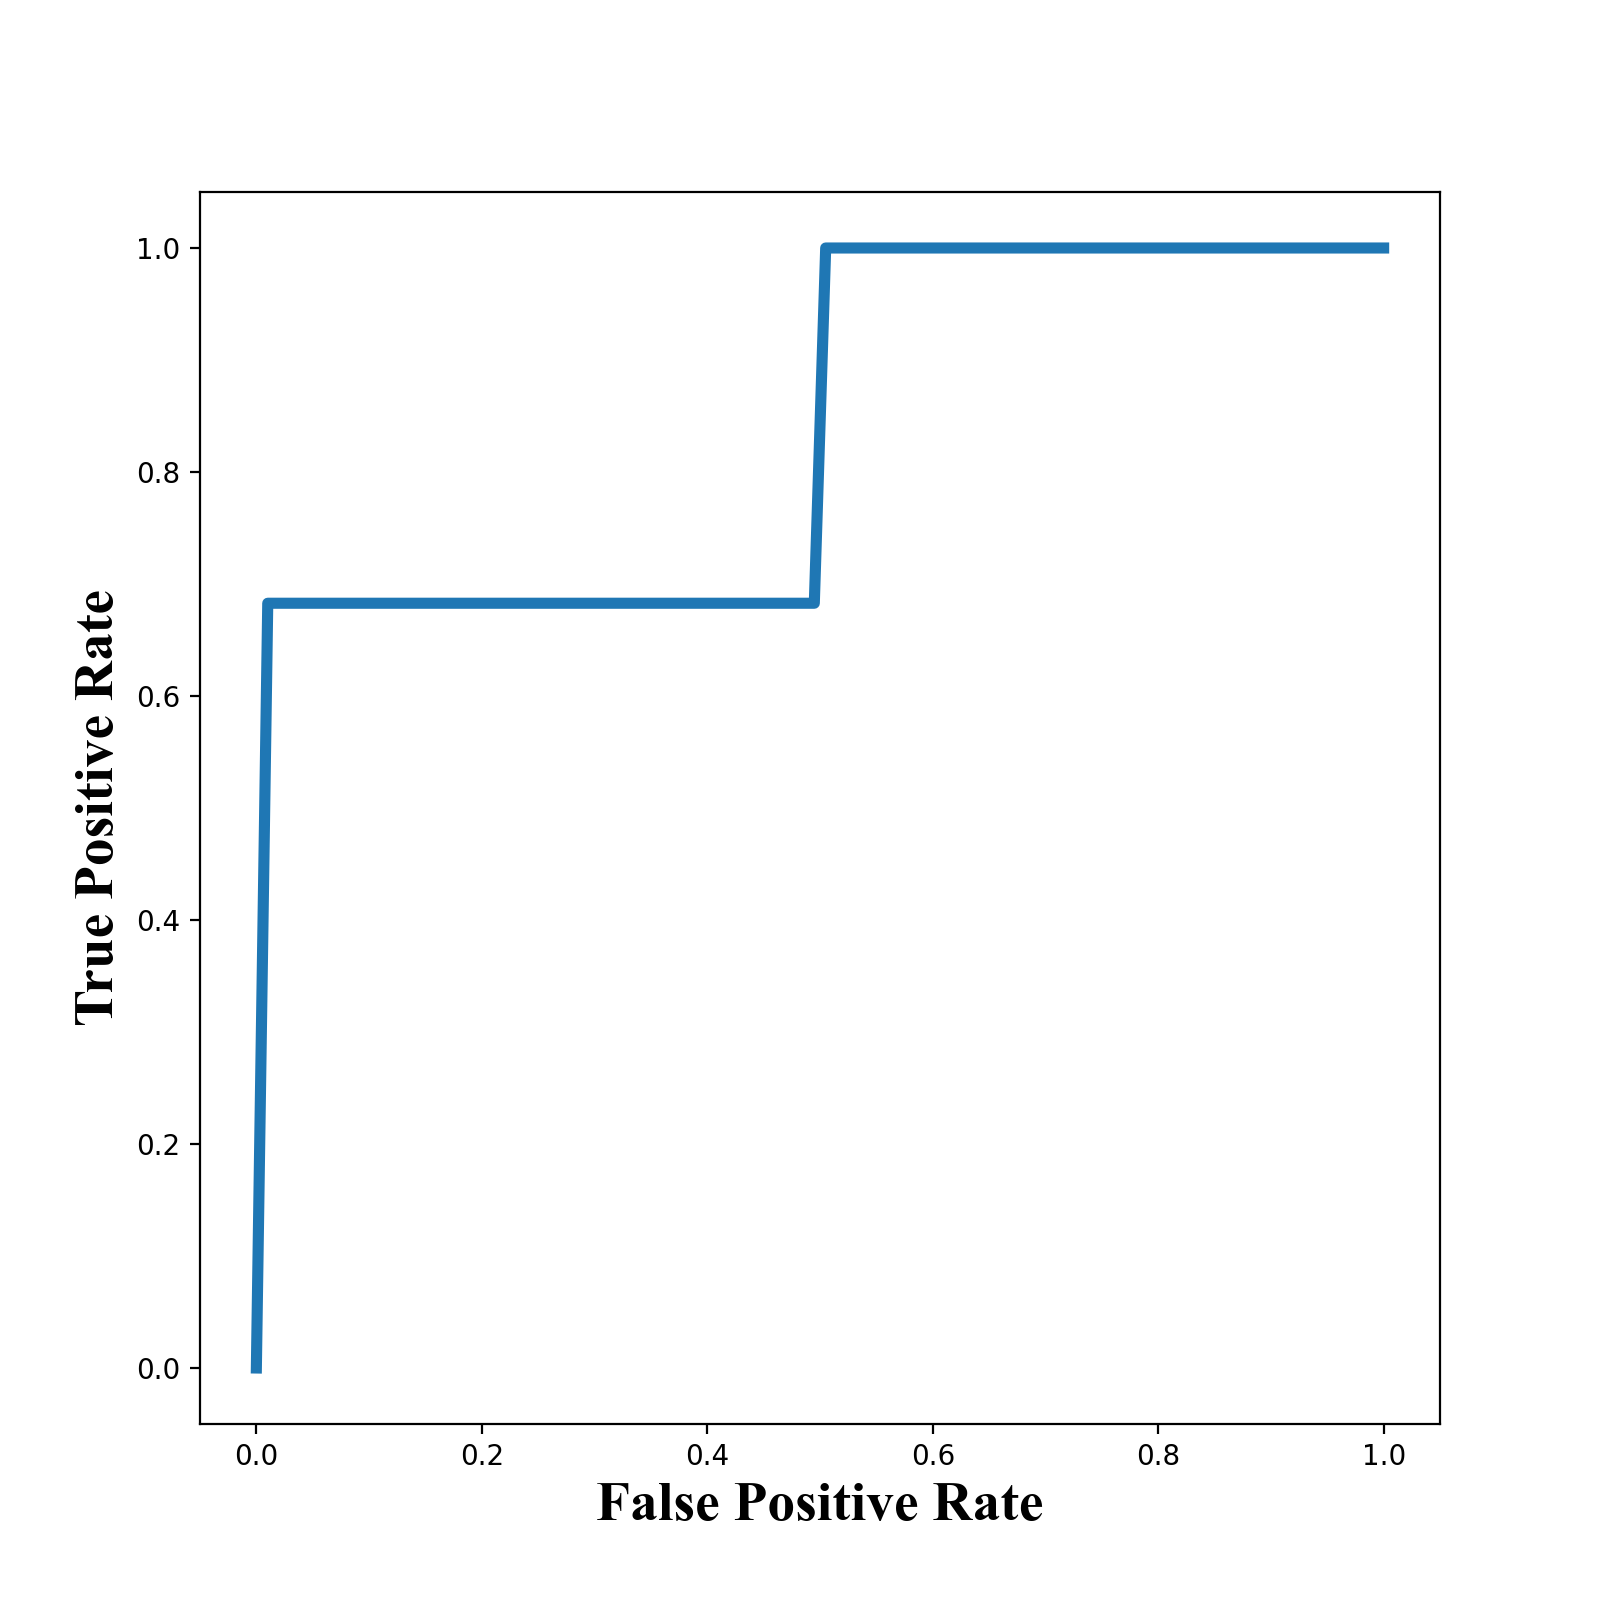

Original ROC area: 0.839
Confidence interval for the score: [0.839 - 0.84]


Text(0, 0.5, 'True Positive Rate')

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve
import scipy
hfont = {'fontname':'Times New Roman'}

y_pred = y_test_pred
y_true = np.array(y_test)

    
plt.figure( figsize=(8,8) ) 
utils.plot_ROC_confidence_intervals(y_true, y_pred)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=20, **hfont)
plt.ylabel('True Positive Rate', fontsize=20, **hfont)

In [38]:
C = clf.C_

# Following code uses statsmodels and takes too long to run

In [39]:
start = time.time()
clf = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit_regularized()
end = time.time()
print('training time: %d'%(end-start))

/opt/anaconda3/envs/ML_tensorflow/lib/python3.7/site-packages/statsmodels/base/elastic_net.py:332: RuntimeWarning: invalid value encountered in double_scalars
  h = (L1_wt - b) / c


training time: 7931


In [40]:
clf.params

const                                 -4.516255e-01
time                                   4.626840e-02
warning_issued                        -6.300984e+00
year                                   2.688247e-03
yearfrac                              -3.272163e-02
subject_race_asian/pacific islander    2.158669e-01
subject_race_black                     4.555451e-01
subject_race_hispanic                  6.034860e-01
subject_race_other                     1.746233e-01
subject_race_nan                       2.110349e+02
subject_sex_female                    -5.382769e-01
subject_sex_male                      -4.029260e-01
subject_sex_nan                       -3.288849e-02
contraband_found_FALSE                 1.466217e+00
contraband_found_TRUE                  3.902847e+00
contraband_found_nan                  -2.524783e-02
contraband_drugs_FALSE                 7.824665e-02
contraband_drugs_TRUE                  1.572292e-01
contraband_drugs_nan                  -3.887342e-05
contraband_w

In [48]:
clf.summary()

NotImplementedError: 

In [46]:
# training accuracy
y_train_pred = clf.predict(X_train)
y_train_pred_thresh = y_train_pred.copy()
y_train_pred_thresh[y_train_pred_thresh < 0.5] = 0
y_train_pred_thresh[y_train_pred_thresh >= 0.5] = 1
np.mean(y_train_pred_thresh == y_train)

0.8744738364583281

In [47]:
# testing accuracy
y_test_pred = clf.predict(X_test)
y_test_pred_thresh = y_test_pred.copy()
y_test_pred_thresh[y_test_pred_thresh < 0.5] = 0
y_test_pred_thresh[y_test_pred_thresh >= 0.5] = 1
np.mean(y_test_pred_thresh == y_test)

0.8744009295172832